In [1]:
from conf import databases, url, data_dir

In [2]:
import wfdb
import numpy
import json
import os
import glob
import random

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv1D, MaxPooling1D
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import TimeDistributed
from keras.optimizers import RMSprop
from keras.callbacks import TensorBoard, LambdaCallback, ModelCheckpoint
from matplotlib import pyplot as plt
import matplotlib as mpl

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [4]:
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:
        pass

In [ ]:
def normalize(x, lb=0, ub=1):
    mid = ub - (ub - lb) / 2
    min_v = numpy.min(x)
    max_v = numpy.max(x)
    mid_v =  max_v - (max_v - min_v) / 2
    coef = (ub - lb) / (max_v - min_v)
    return x * coef - (mid_v * coef) + mid
    
for db, ids in databases:
    for i in ids:
        f = data_dir + db + '/' + i
        if os.path.isfile(f + '.normalized.dnn.npz'):
            continue
        print(f, end='')
        sig, fields = wfdb.srdsamp(f)
        ann = wfdb.rdann(f, 'atr')
        if not numpy.array_equal(ann.chan, numpy.full(len(ann.chan), ann.chan[0])):
            print(' Not good...')
            continue
        x = normalize(sig[:, ann.chan[0]])
        y = numpy.zeros(len(x))
        for v in ann.annsamp:
            y[v] = 1
        numpy.savez_compressed(f + '.normalized.dnn.npz', numpy.asarray([x, y]))
        print()

In [3]:
# NN params
segment_size = 5000
segment_step = 2500
y_delay = 0

train_perc = 90
test_perc = 100 - train_perc

In [4]:
def load_fnpz(filepath):
    xy = numpy.load(f, mmap_mode='r', allow_pickle=True)['arr_0']
    return xy[0,:], xy[1,:]

# Load data
XY_file = data_dir + 'mitdb/XY_delay{}-5000-2500.normalized.dnn.npz'.format(y_delay)
if os.path.isfile(XY_file):
    XY = numpy.load(XY_file, mmap_mode='r', allow_pickle=True)['arr_0']
else:
    sigs = []
    for f in glob.glob(data_dir + 'mitdb/*.normalized.dnn.npz'):
        x, y = load_fnpz(f)
        sigs.append((x, y))
    XY = []
    for (x, y) in sigs:
        for i in range(0, len(x)+1-segment_size, segment_step):
            if y_delay == 0:
                XY.append((
                        [[e] for e in x[i:i+segment_size]],
                        [[e] for e in y[i:i+segment_size-y_delay]]))
            else:
                # We pad y labels with *y_delay* zeros (so that RNN has some future context to predict classes)
                XY.append((
                    [[e] for e in x[i:i+segment_size]],
                    numpy.concatenate(([[0] for e in range(y_delay)], [[e] for e in y[i:i+segment_size-y_delay]]))[:segment_size]
                ))
    random.shuffle(XY)
    numpy.savez_compressed(XY_file, XY)
print('Constructed {} examples of length {} with a delay of {} sample(s).'.format(len(XY), segment_size, y_delay))

s = int(len(XY) * train_perc/100)
trainXY, testXY = XY[:s], XY[s:]

print('- {} training examples ({}%)'.format(len(trainXY), train_perc))
print('- {} testing examples ({}%)'.format(len(testXY), test_perc))
trainXY = numpy.asarray(trainXY)
testXY = numpy.asarray(testXY)

Constructed 12432 examples of length 5000 with a delay of 0 sample(s).
- 11188 training examples (90%)
- 1244 testing examples (10%)


In [8]:
print(trainXY[0,1].astype('int32').tolist())

[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0],

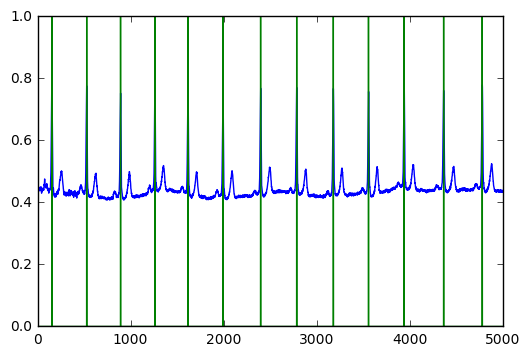

In [7]:
plt.plot(trainXY[1,0])
plt.plot(trainXY[1,1])
plt.show()

In [8]:
print(trainXY.shape[0])
print(testXY.shape)
unique_items, counts = numpy.unique(trainXY[:,1], return_counts=True)
ratio_zero_one = counts[0]/counts[1]
print(ratio_zero_one)

11188
(1244, 2, 5000, 1)
276.043156133


In [21]:
from keras import backend as K
from theano.tensor import basic as tensor
_EPSILON = 10e-8
import tensorflow as tf
from keras.backend.tensorflow_backend import _to_tensor
from tensorflow.python.framework import ops
from tensorflow.python.ops import math_ops as mo
from tensorflow.python.ops import nn_ops
from tensorflow.python.ops import nn
from sklearn.metrics import f1_score
    
    
def rp(y_true, y_pred):
    # Rpeaks
    return K.sum(y_pred)/K.sum(y_true)

def se(y_true, y_pred):
    # Sensibility, recall, TPR
    TP = mo.reduce_sum(mo.multiply(y_true, y_pred))
    RP = mo.reduce_sum(y_true)
    return TP/RP

def sp(y_true, y_pred):
    # Specificity, TNR
    TN = mo.reduce_sum(mo.multiply(1-y_true, 1-y_pred))
    RN = mo.reduce_sum(1-y_true)
    return TN/RN    

def mmc(y_true, y_pred):
    # Matthews correlation coefficient
    TP = mo.reduce_sum(mo.multiply(y_true, y_pred))        # Correctly predicted as positive
    TN = mo.reduce_sum(mo.multiply(1-y_true, 1-y_pred))    # Correctly predicted as negative
    FP = mo.reduce_sum(mo.multiply(1-y_true, y_pred))      # Falsely predicted as positive
    FN = mo.reduce_sum(mo.multiply(y_true, 1-y_pred))      # Falsely predicted as negative
    return (TP*TN - FP*FN) / K.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))

def my_loss(targets, logits, name=None):
    with ops.name_scope(name, "logistic_loss", [logits, targets]) as name:
        logits = ops.convert_to_tensor(logits, name="logits")
        targets = ops.convert_to_tensor(targets, name="targets")
        try:
            targets.get_shape().merge_with(logits.get_shape())
        except ValueError:
            raise ValueError("logits and targets must have the same shape (%s vs %s)"
                           % (logits.get_shape(), targets.get_shape()))
        #return math_ops.add(ratio_zero_one*(1-logits)*targets, (1-targets)*logits, name=name)
        loss_tp = mo.abs(mo.log(mo.div(
                    mo.reduce_sum(mo.multiply(targets, logits)),
                    mo.reduce_sum(targets))))
        loss_tn = mo.abs(mo.log(mo.div(
                    mo.reduce_sum(mo.multiply((1-targets), (1-logits))),
                    mo.reduce_sum((1-targets)))))
        return mo.add(loss_tp, loss_tn)
    
def my_loss2(targets, logits, name=None):
    with ops.name_scope(name, "logistic_loss", [logits, targets]) as name:
        logits = ops.convert_to_tensor(logits, name="logits")
        targets = ops.convert_to_tensor(targets, name="targets")
        try:
            targets.get_shape().merge_with(logits.get_shape())
        except ValueError:
            raise ValueError("logits and targets must have the same shape (%s vs %s)"
                           % (logits.get_shape(), targets.get_shape()))
        #return math_ops.add(ratio_zero_one*(1-logits)*targets, (1-targets)*logits, name=name)
        TP = mo.reduce_sum(mo.multiply(targets, logits))     # Correctly predicted as positive
        TN = mo.reduce_sum(mo.multiply(1-targets, 1-logits)) # Correctly predicted as negative
        FP = mo.reduce_sum(mo.multiply(1-targets, logits))      # Falsely predicted as positive
        FN = mo.reduce_sum(mo.multiply(targets, 1-logits))      # Falsely predicted as negative
        
        PP = mo.add(TP, FP)
        
        RP = mo.reduce_sum(targets) # Number of real positives
        RN = mo.reduce_sum(1-targets) # Number of real negatives
        
        loss_tp = mo.abs(mo.log(mo.div(TP, RP)))
        loss_tn = mo.abs(mo.log(mo.div(TN, RN)))
        loss_fp = mo.log(mo.div(FP, RP)+1)
        loss_fn = mo.log(mo.div(FN, RN)+1)/4
        
        # Grandement pénaliser si il ne prédit pas de positifs
        loss_nb_p = mo.abs(mo.log(mo.div(PP, RP)))*4
        
#         return mo.add(loss_nb_p, mo.add(mo.add(mo.add(loss_tp, loss_tn), loss_fp), loss_fn))
        return mo.add(loss_tp, loss_tn)

def mmc_loss(targets, logits, name=None):
    with ops.name_scope(name, "logistic_loss", [logits, targets]) as name:
        logits = ops.convert_to_tensor(logits, name="logits")
        targets = ops.convert_to_tensor(targets, name="targets")
        try:
            targets.get_shape().merge_with(logits.get_shape())
        except ValueError:
            raise ValueError("logits and targets must have the same shape (%s vs %s)"
                           % (logits.get_shape(), targets.get_shape()))
        return mo.exp(1-mmc(y_true=targets, y_pred=logits))

def my_ce(y_true, y_pred):
    return K.mean(nn.weighted_cross_entropy_with_logits(targets=y_true, logits=y_pred, pos_weight=ratio_zero_one), axis=-1)

# model1 = Sequential()
# model1.add(LSTM(units=512, input_shape=(segment_size, 1), return_sequences=True))
# model1.add(Dense(1, activation='sigmoid'))
# model1.compile(loss=my_loss, optimizer='adam', metrics=['accuracy', Rpeaks_metric])


# model2 = Sequential()
# model2.add(LSTM(units=1024, input_shape=(segment_size, 1), return_sequences=True))
# model2.add(Dense(100))
# model2.add(Dense(1, activation='sigmoid'))
# model2.compile(loss=my_loss, optimizer='adam', metrics=['accuracy', Rpeaks_metric])

# model3 = Sequential()
# model3.add(LSTM(units=256, input_shape=(segment_size, 1), return_sequences=True))
# model3.add(Dense(1, activation='sigmoid'))
# model3.compile(loss=my_loss, optimizer='adam', metrics=['accuracy', rpeaks])

# model4 = Sequential()
# model4.add(LSTM(units=2048, input_shape=(segment_size, 1), return_sequences=True))
# model4.add(Dense(1, activation='sigmoid'))
# model4.compile(loss=my_loss, optimizer='adam', metrics=['accuracy', rpeaks])

# model5 = Sequential()
# model5.add(Conv1D(128, 10, padding='valid', activation='relu', strides=1, input_shape=(segment_size, 1)))
# model5.add(MaxPooling1D(pool_size=8))
# model5.add(LSTM(256, return_sequences=True))
# model5.add(Dense(1, activation='sigmoid'))
# model5.compile(loss=my_loss, optimizer='adam', metrics=['accuracy', rpeaks])

# model6 = Sequential()
# model6.add(Dense(3000, input_shape=(segment_size, 1)))
# model6.add(Conv1D(256, 5, padding='same'))
# model6.add(Dense(500))
# model6.add(Dense(1, activation='sigmoid'))
# model6.compile(loss=my_loss, optimizer='adam', metrics=['accuracy', se, sp, mmc, rpeaks])

mdl_name = "dense3000-conv1d256-dense500-dense1"
model7 = Sequential()
model7.add(Dense(3000, input_shape=(segment_size, 1)))
model7.add(Conv1D(256, 5, padding='same'))
model7.add(Dense(500))
model7.add(Dense(1, activation='sigmoid'))
model7.compile(loss=my_loss, optimizer='adam', metrics=['accuracy', se, sp, mmc, rp])

# SVG(model_to_dot(model).create(prog='dot', format='svg'))

INFO:tensorflow:Summary name dense_19/kernel:0 is illegal; using dense_19/kernel_0 instead.
INFO:tensorflow:Summary name dense_19/kernel:0 is illegal; using dense_19/kernel_0 instead.
INFO:tensorflow:Summary name dense_19/bias:0 is illegal; using dense_19/bias_0 instead.
INFO:tensorflow:Summary name dense_19/bias:0 is illegal; using dense_19/bias_0 instead.
INFO:tensorflow:Summary name conv1d_7/kernel:0 is illegal; using conv1d_7/kernel_0 instead.
INFO:tensorflow:Summary name conv1d_7/kernel:0 is illegal; using conv1d_7/kernel_0 instead.
INFO:tensorflow:Summary name conv1d_7/bias:0 is illegal; using conv1d_7/bias_0 instead.
INFO:tensorflow:Summary name conv1d_7/bias:0 is illegal; using conv1d_7/bias_0 instead.
INFO:tensorflow:Summary name dense_20/kernel:0 is illegal; using dense_20/kernel_0 instead.
INFO:tensorflow:Summary name dense_20/kernel:0 is illegal; using dense_20/kernel_0 instead.
INFO:tensorflow:Summary name dense_20/bias:0 is illegal; using dense_20/bias_0 instead.
INFO:ten

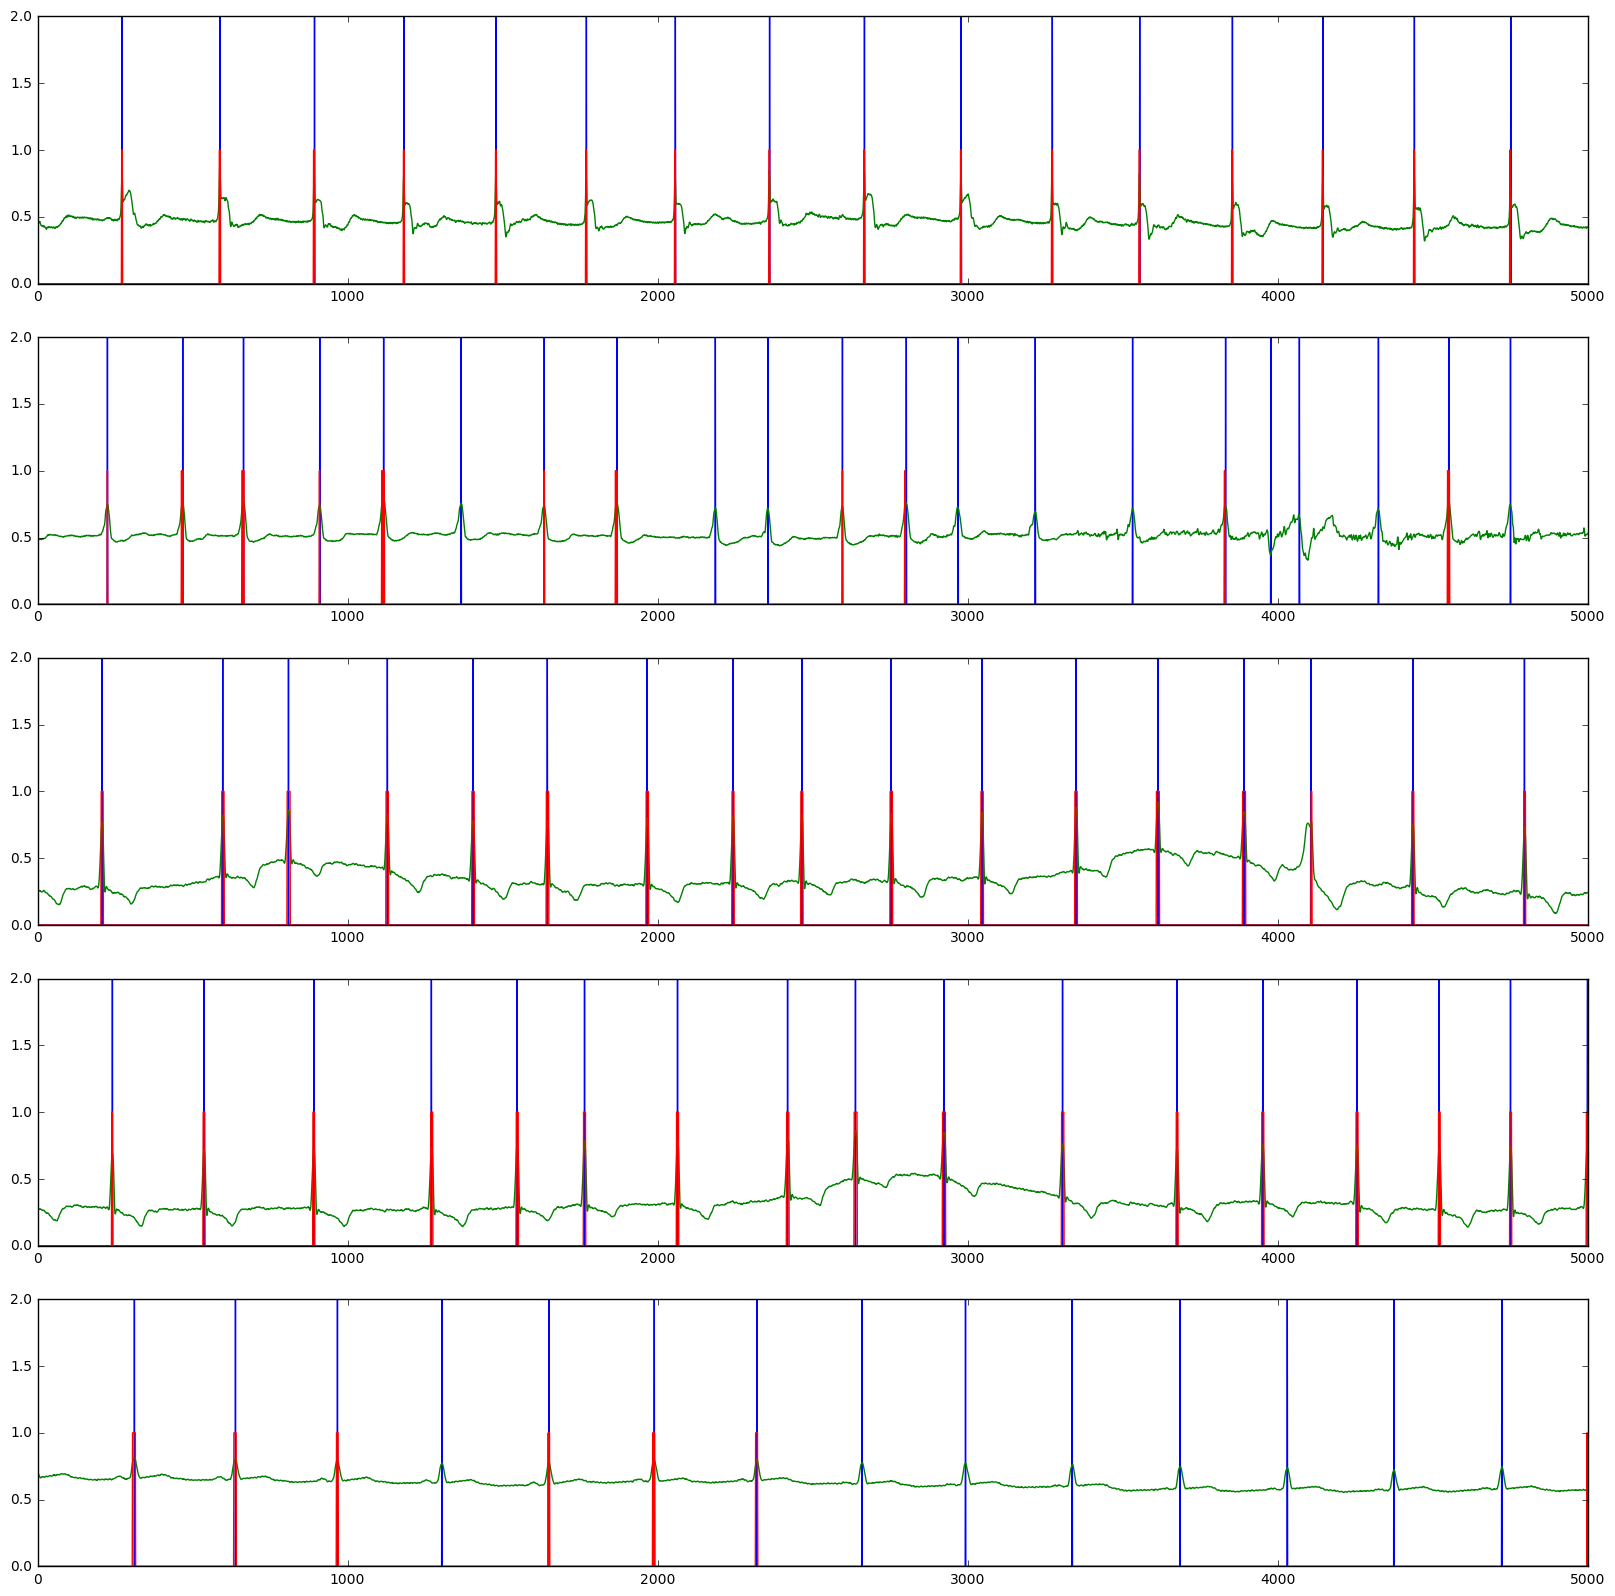

Epoch 94/5000
2/2 [==============================] - 0s


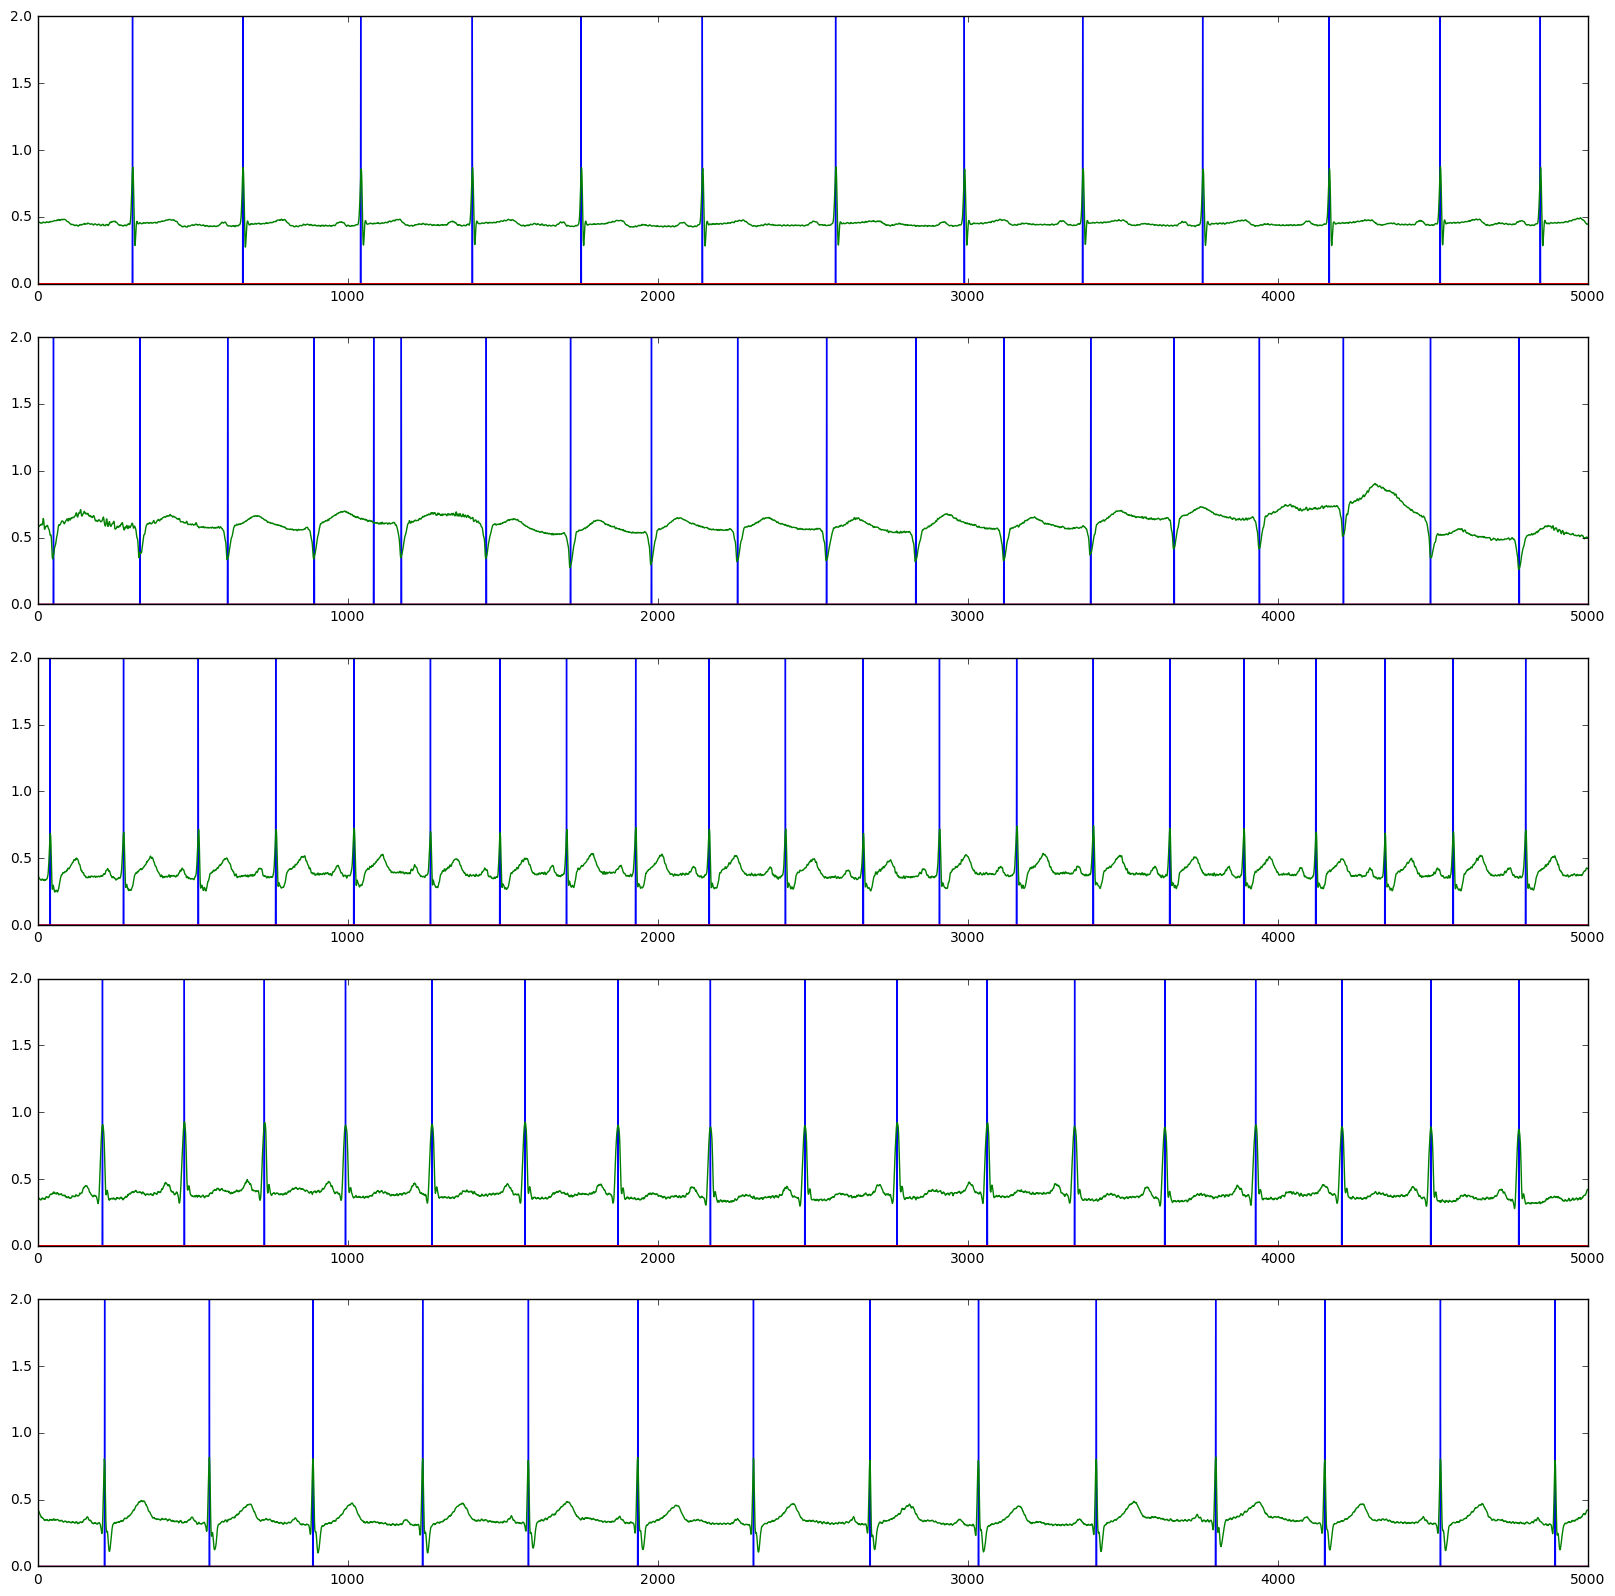

Epoch 95/5000
2/2 [==============================] - 0s


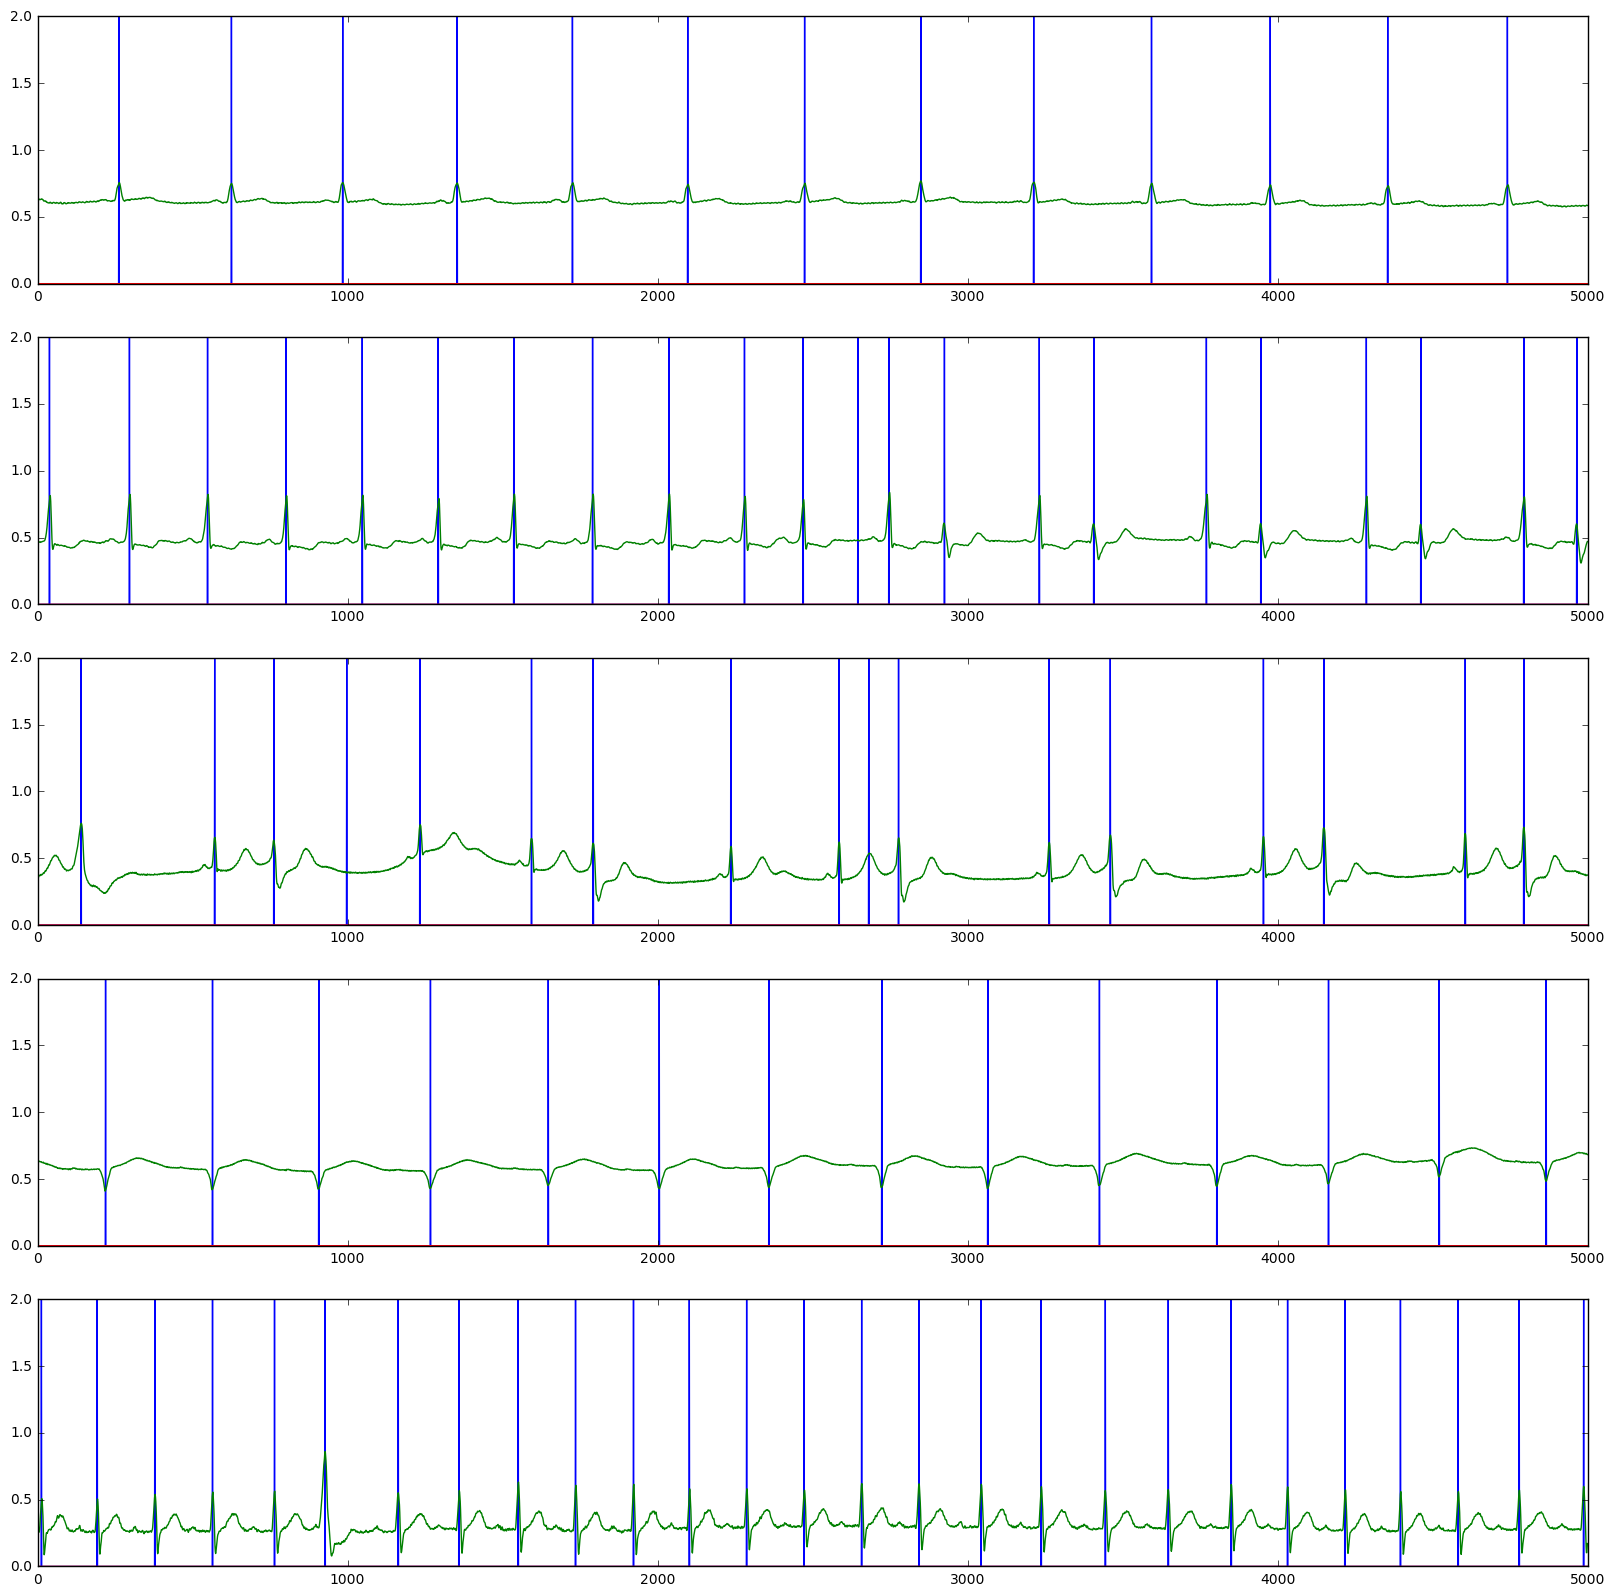

Epoch 96/5000
2/2 [==============================] - 0s


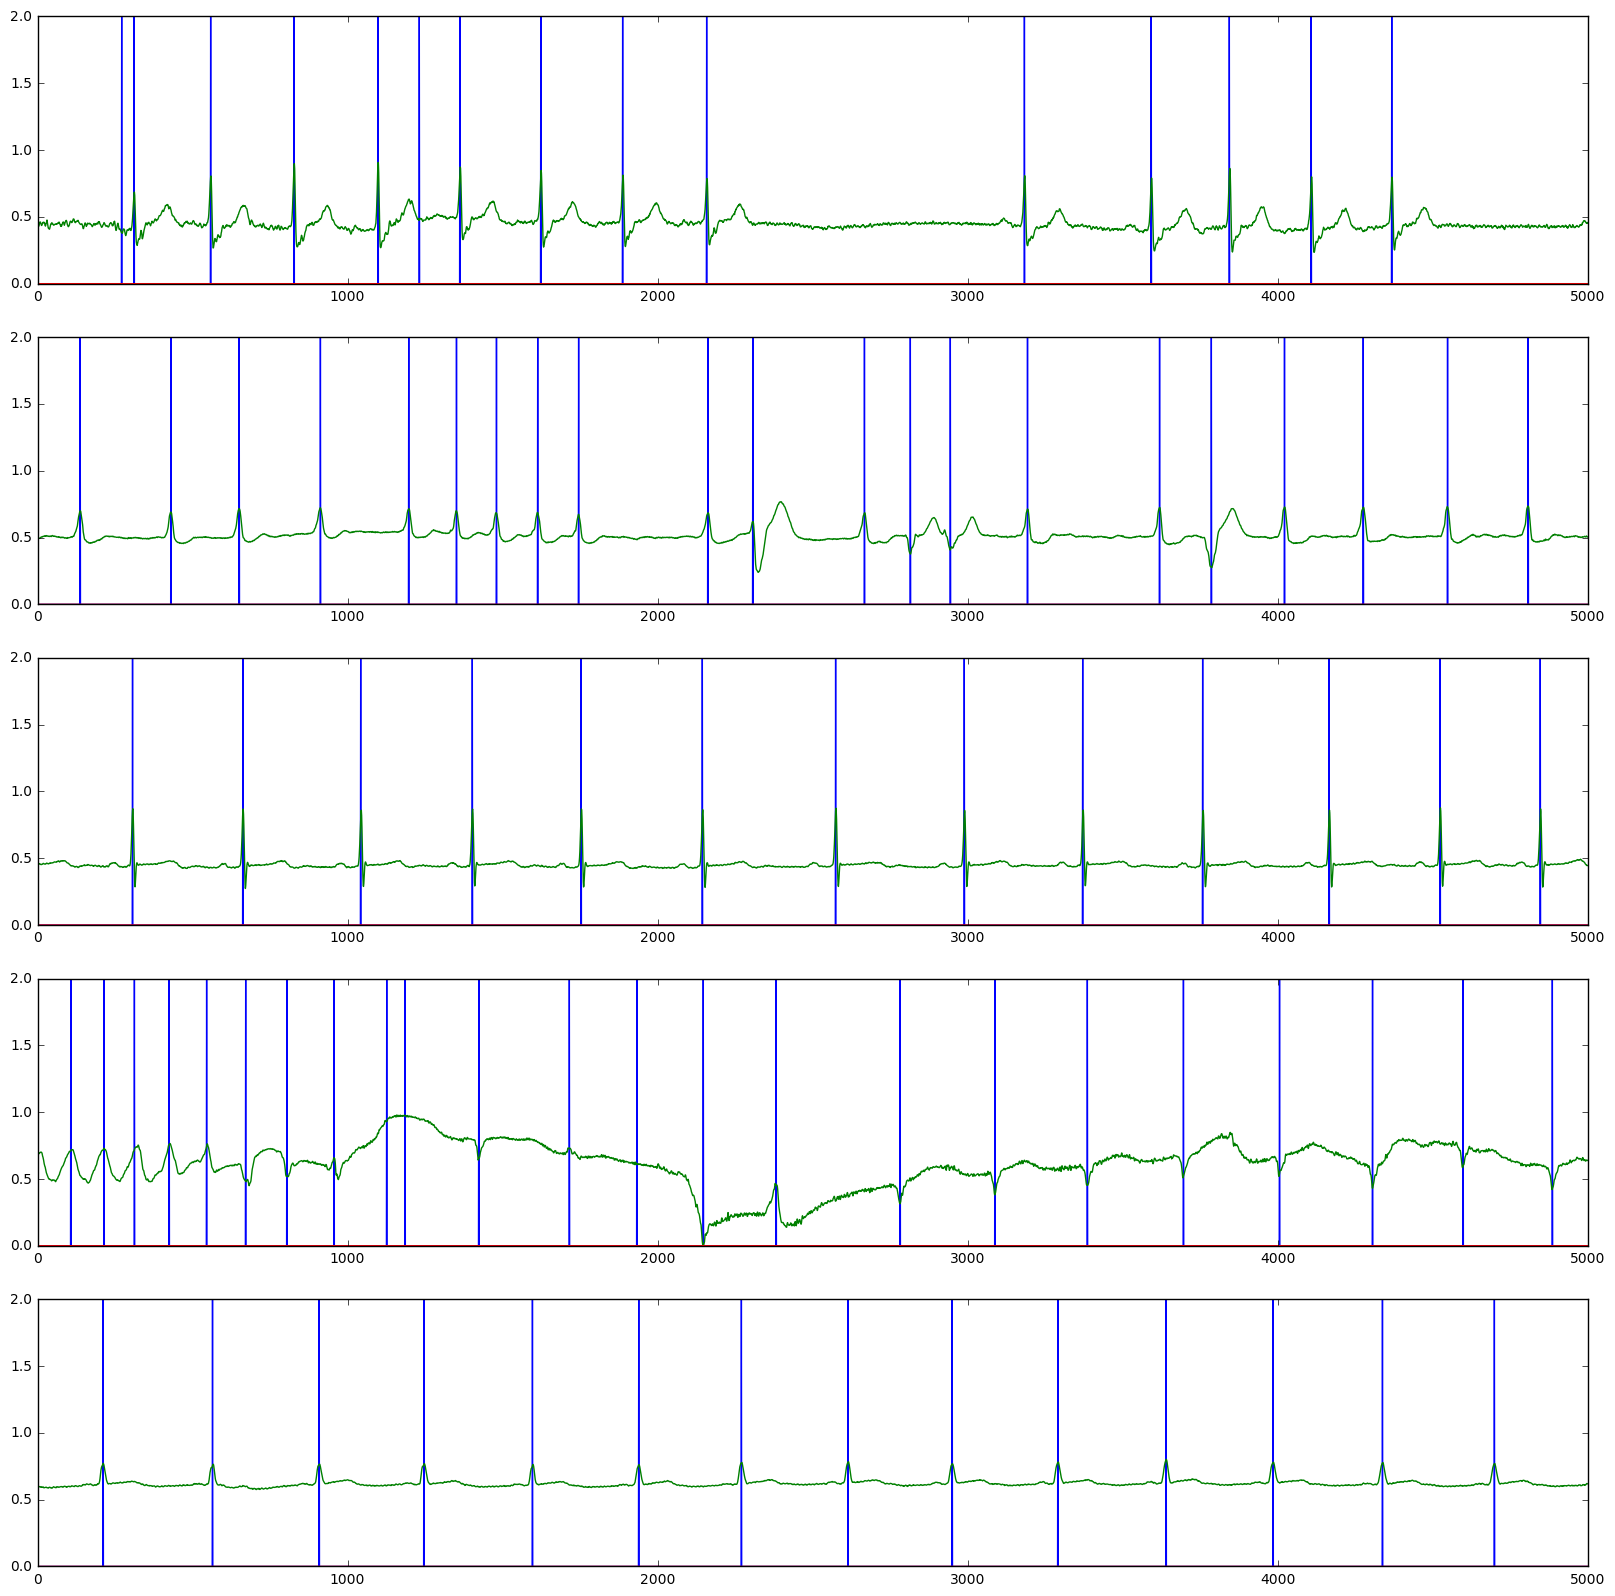

Epoch 97/5000
2/2 [==============================] - 0s


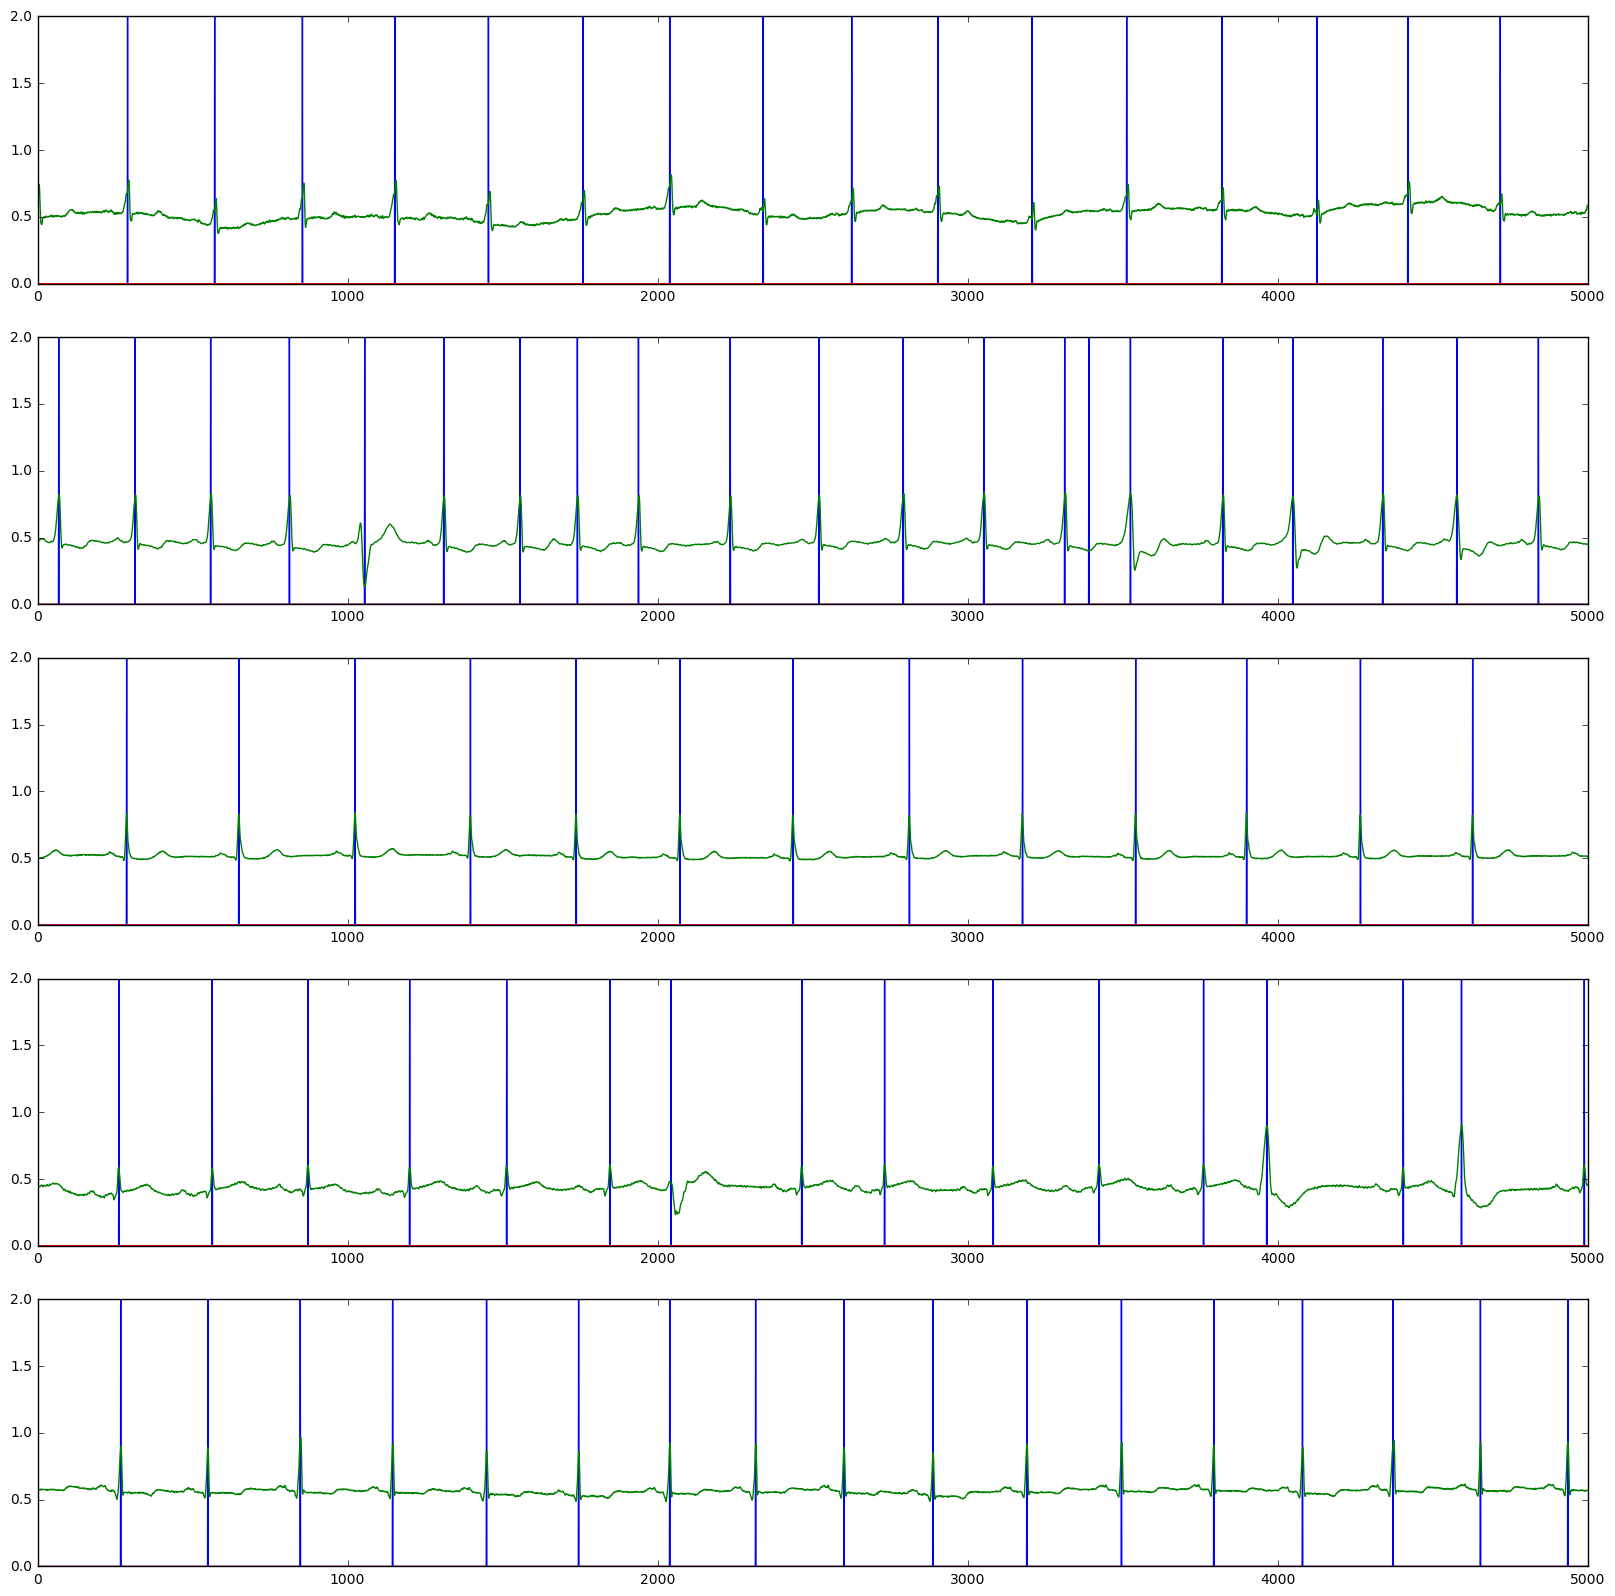

Epoch 98/5000
2/2 [==============================] - 0s


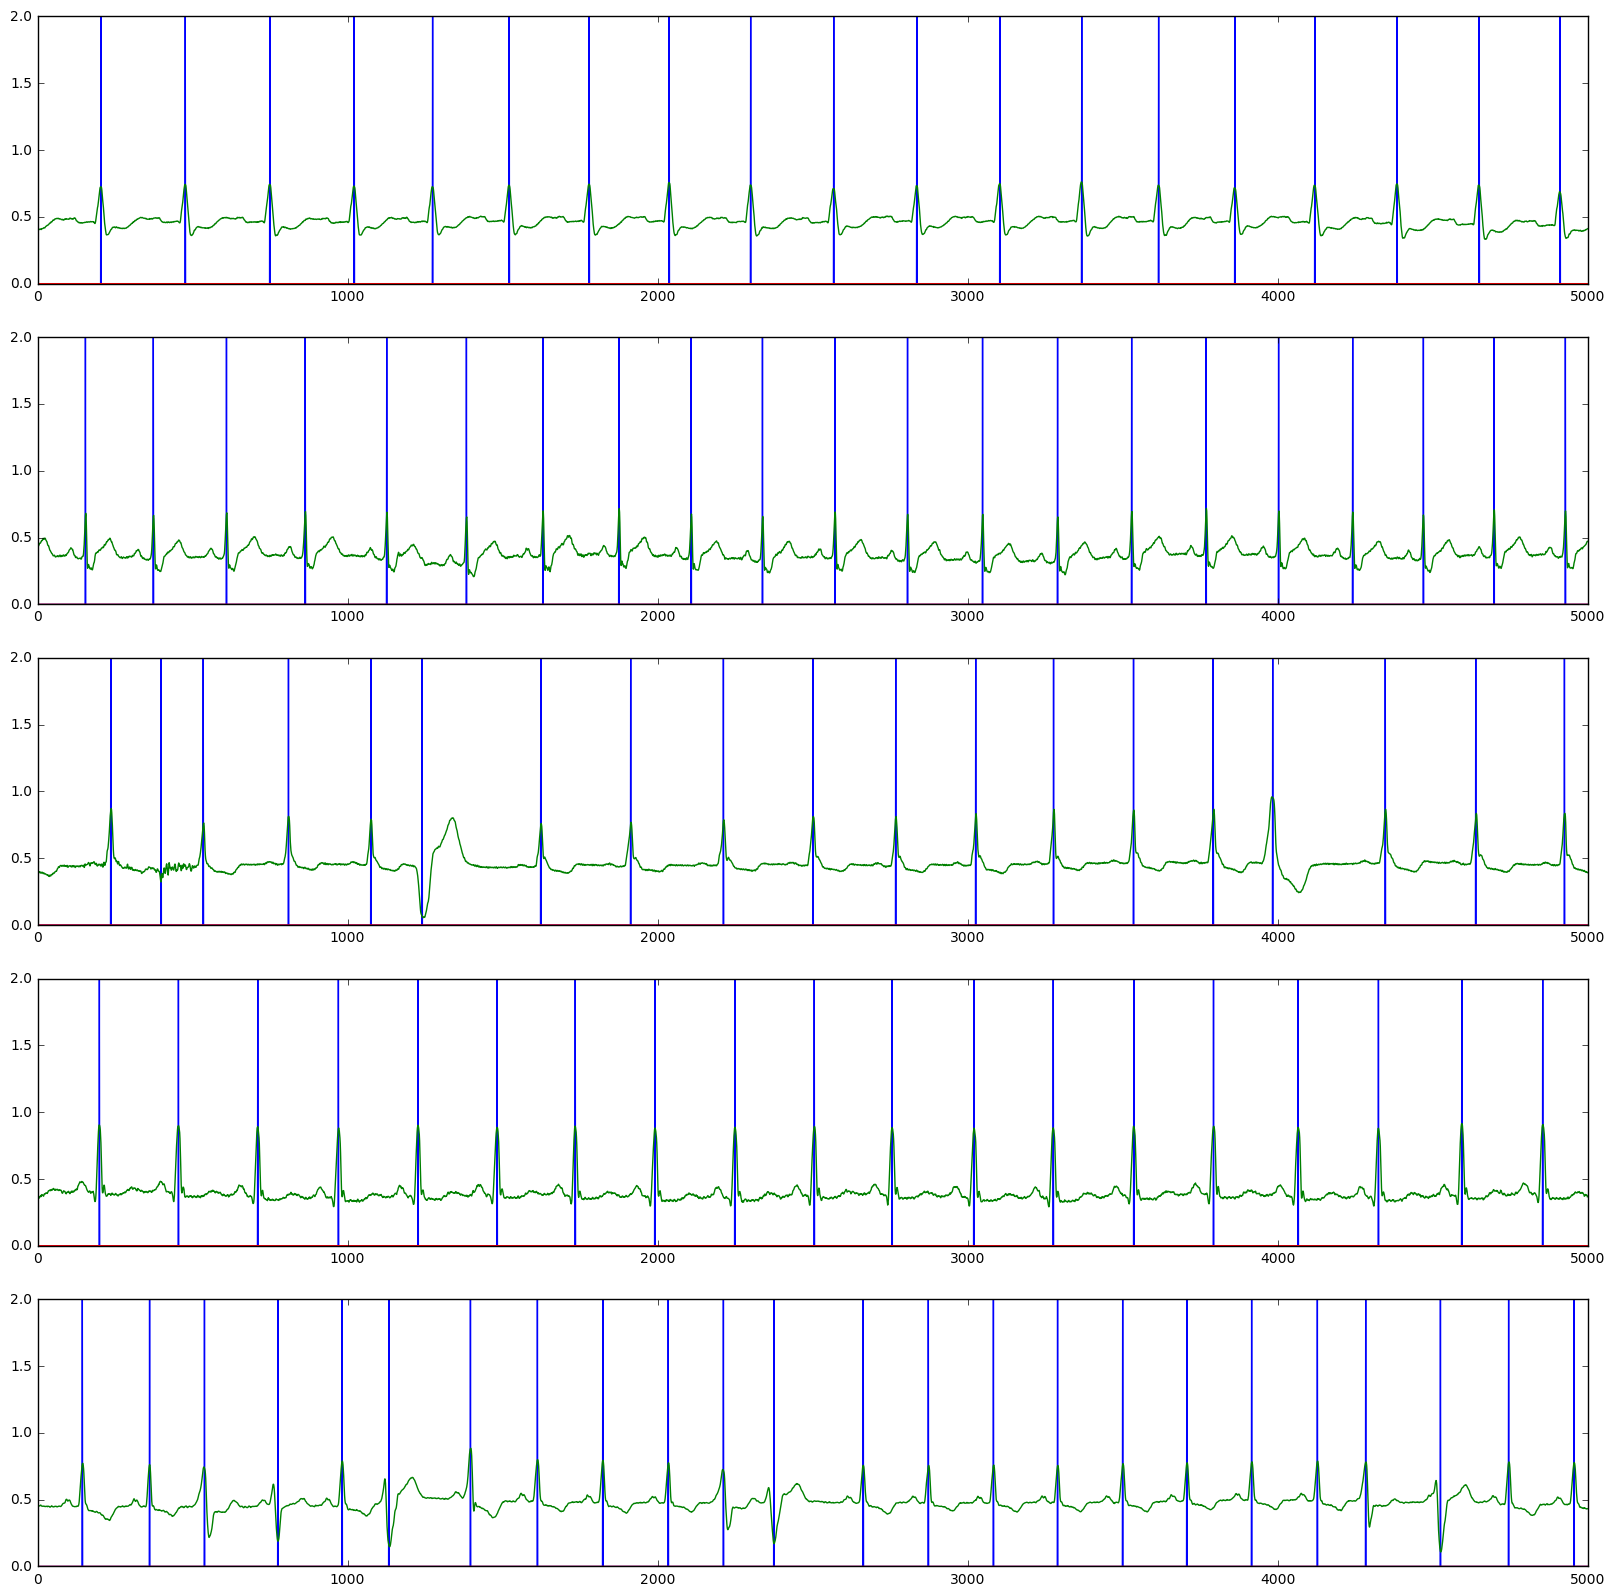

Epoch 99/5000
2/2 [==============================] - 0s


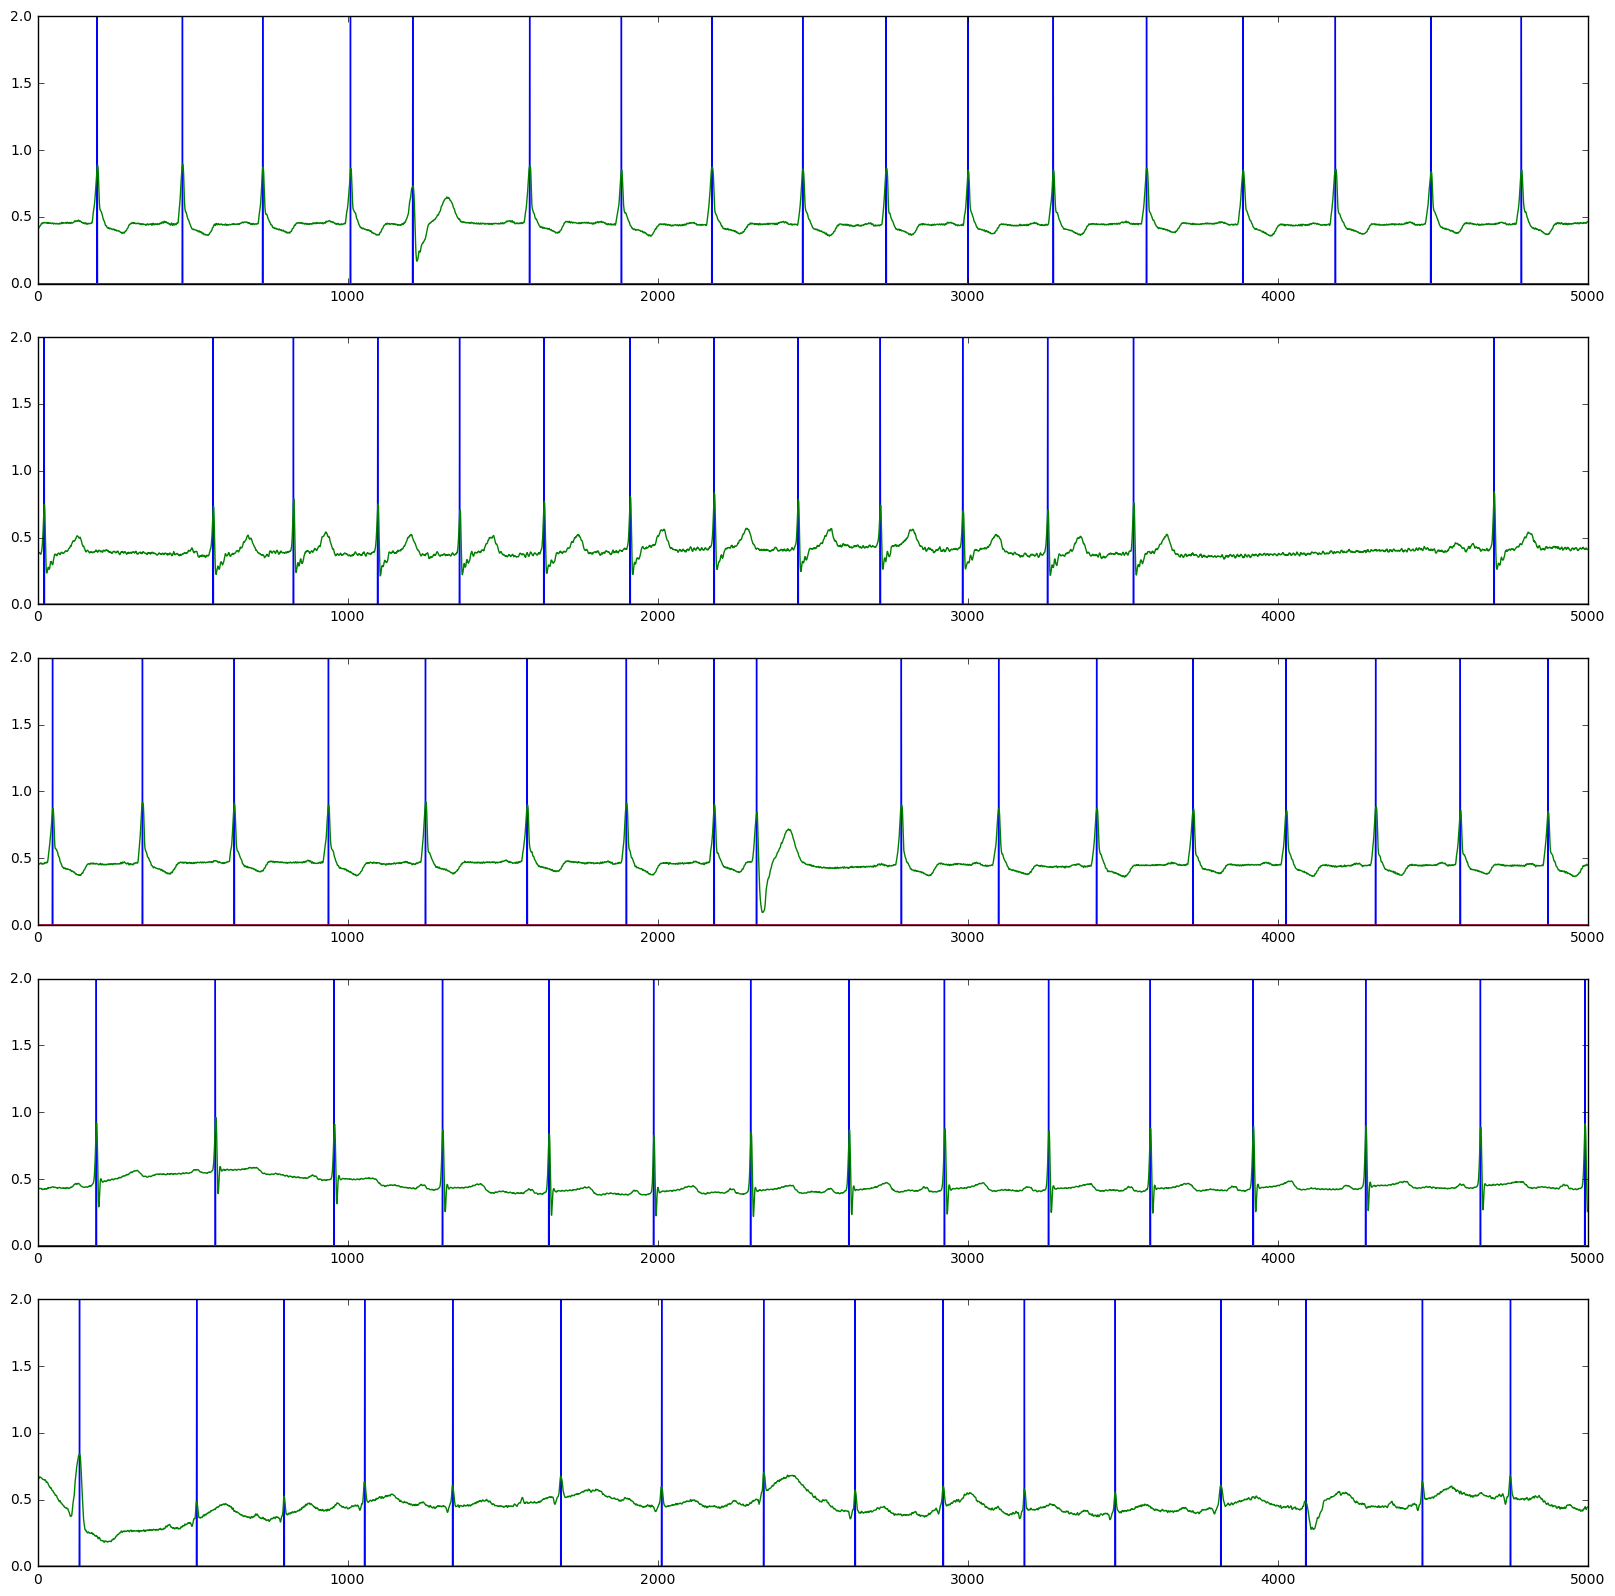

Epoch 100/5000
2/2 [==============================] - 0s


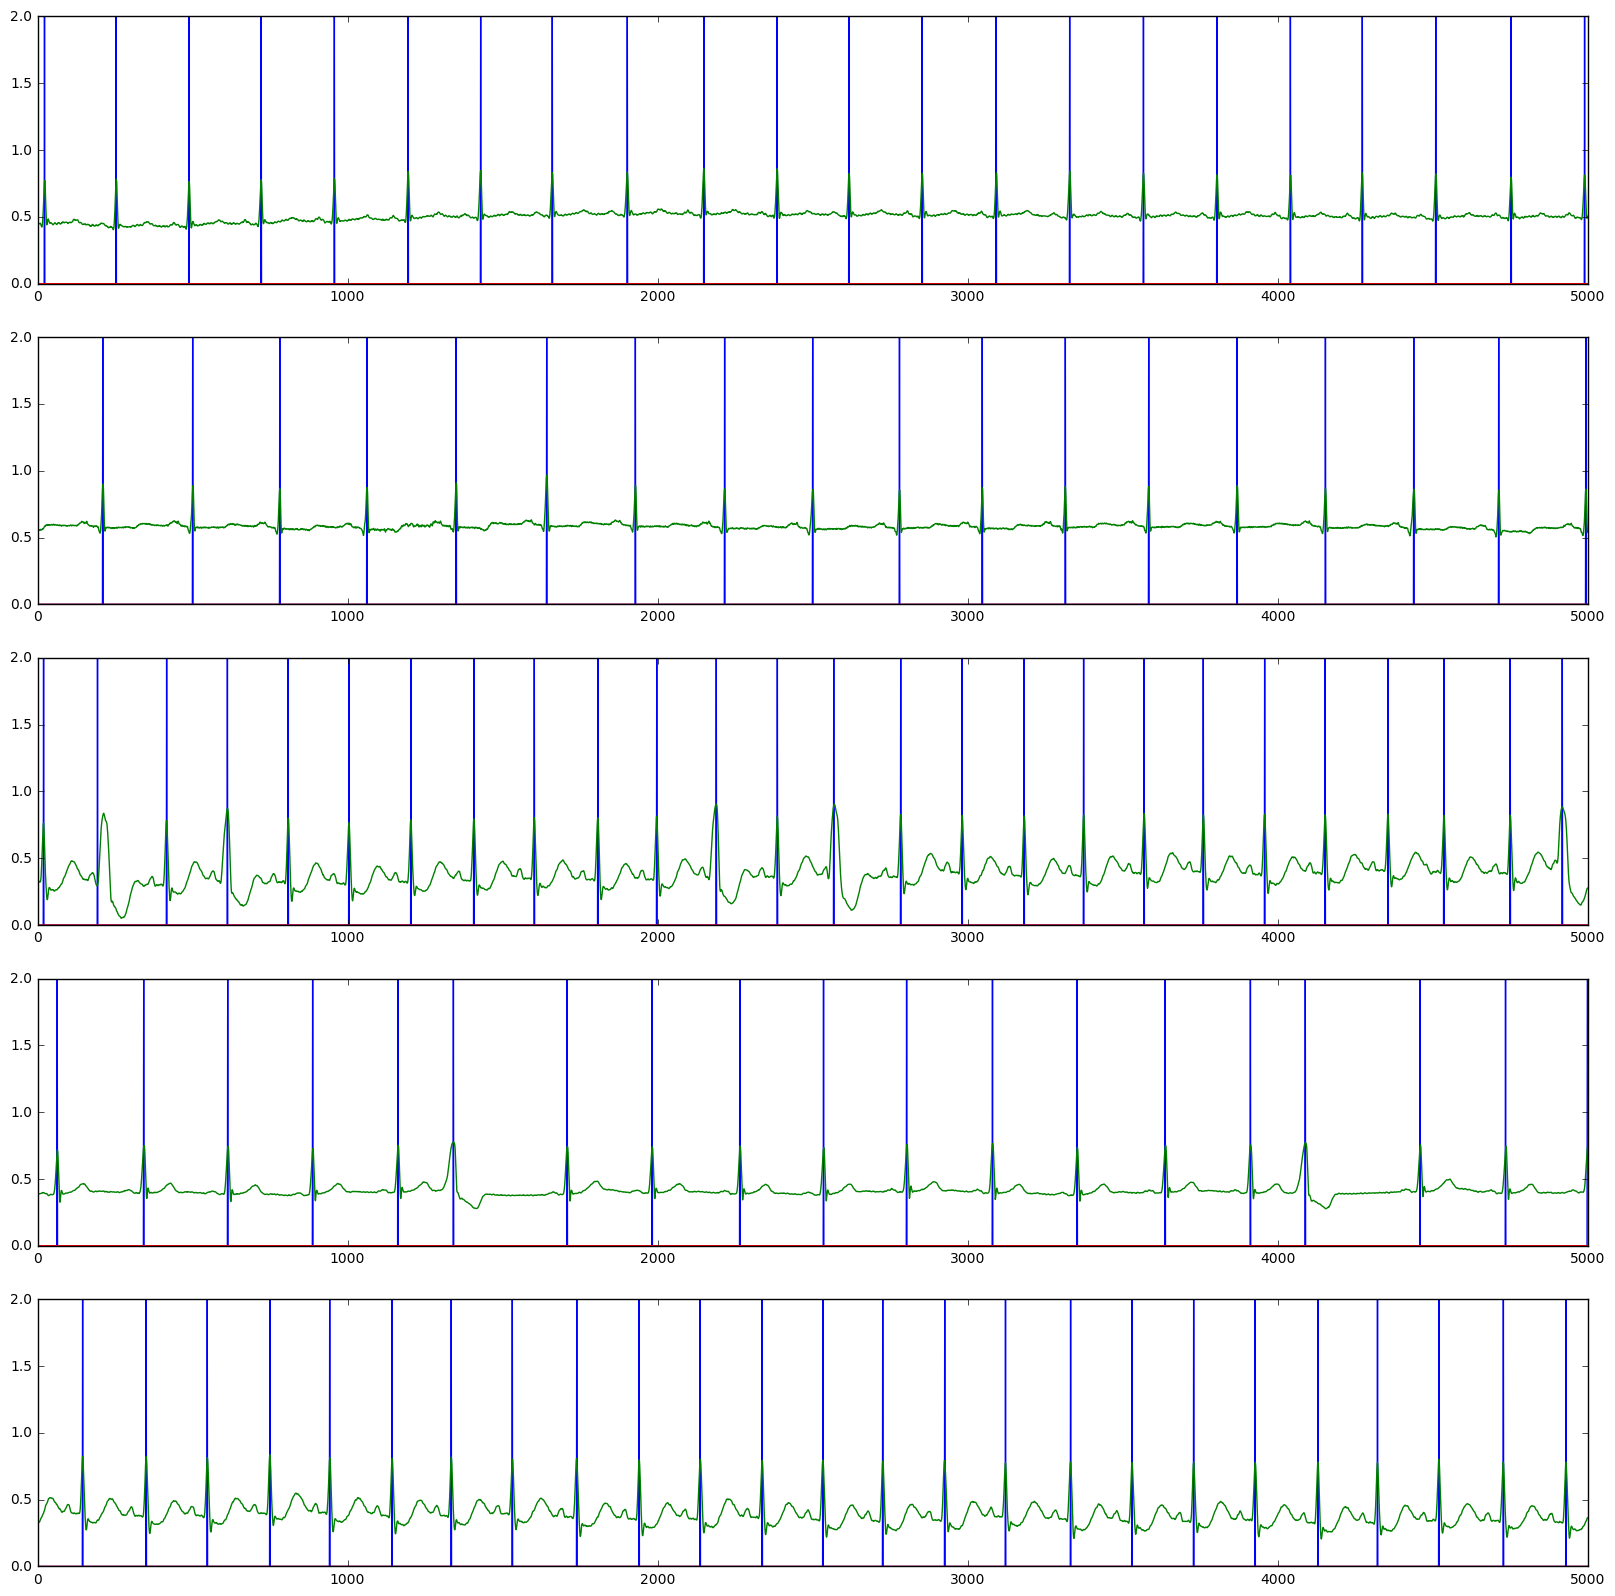

Epoch 101/5000
2/2 [==============================] - 0s


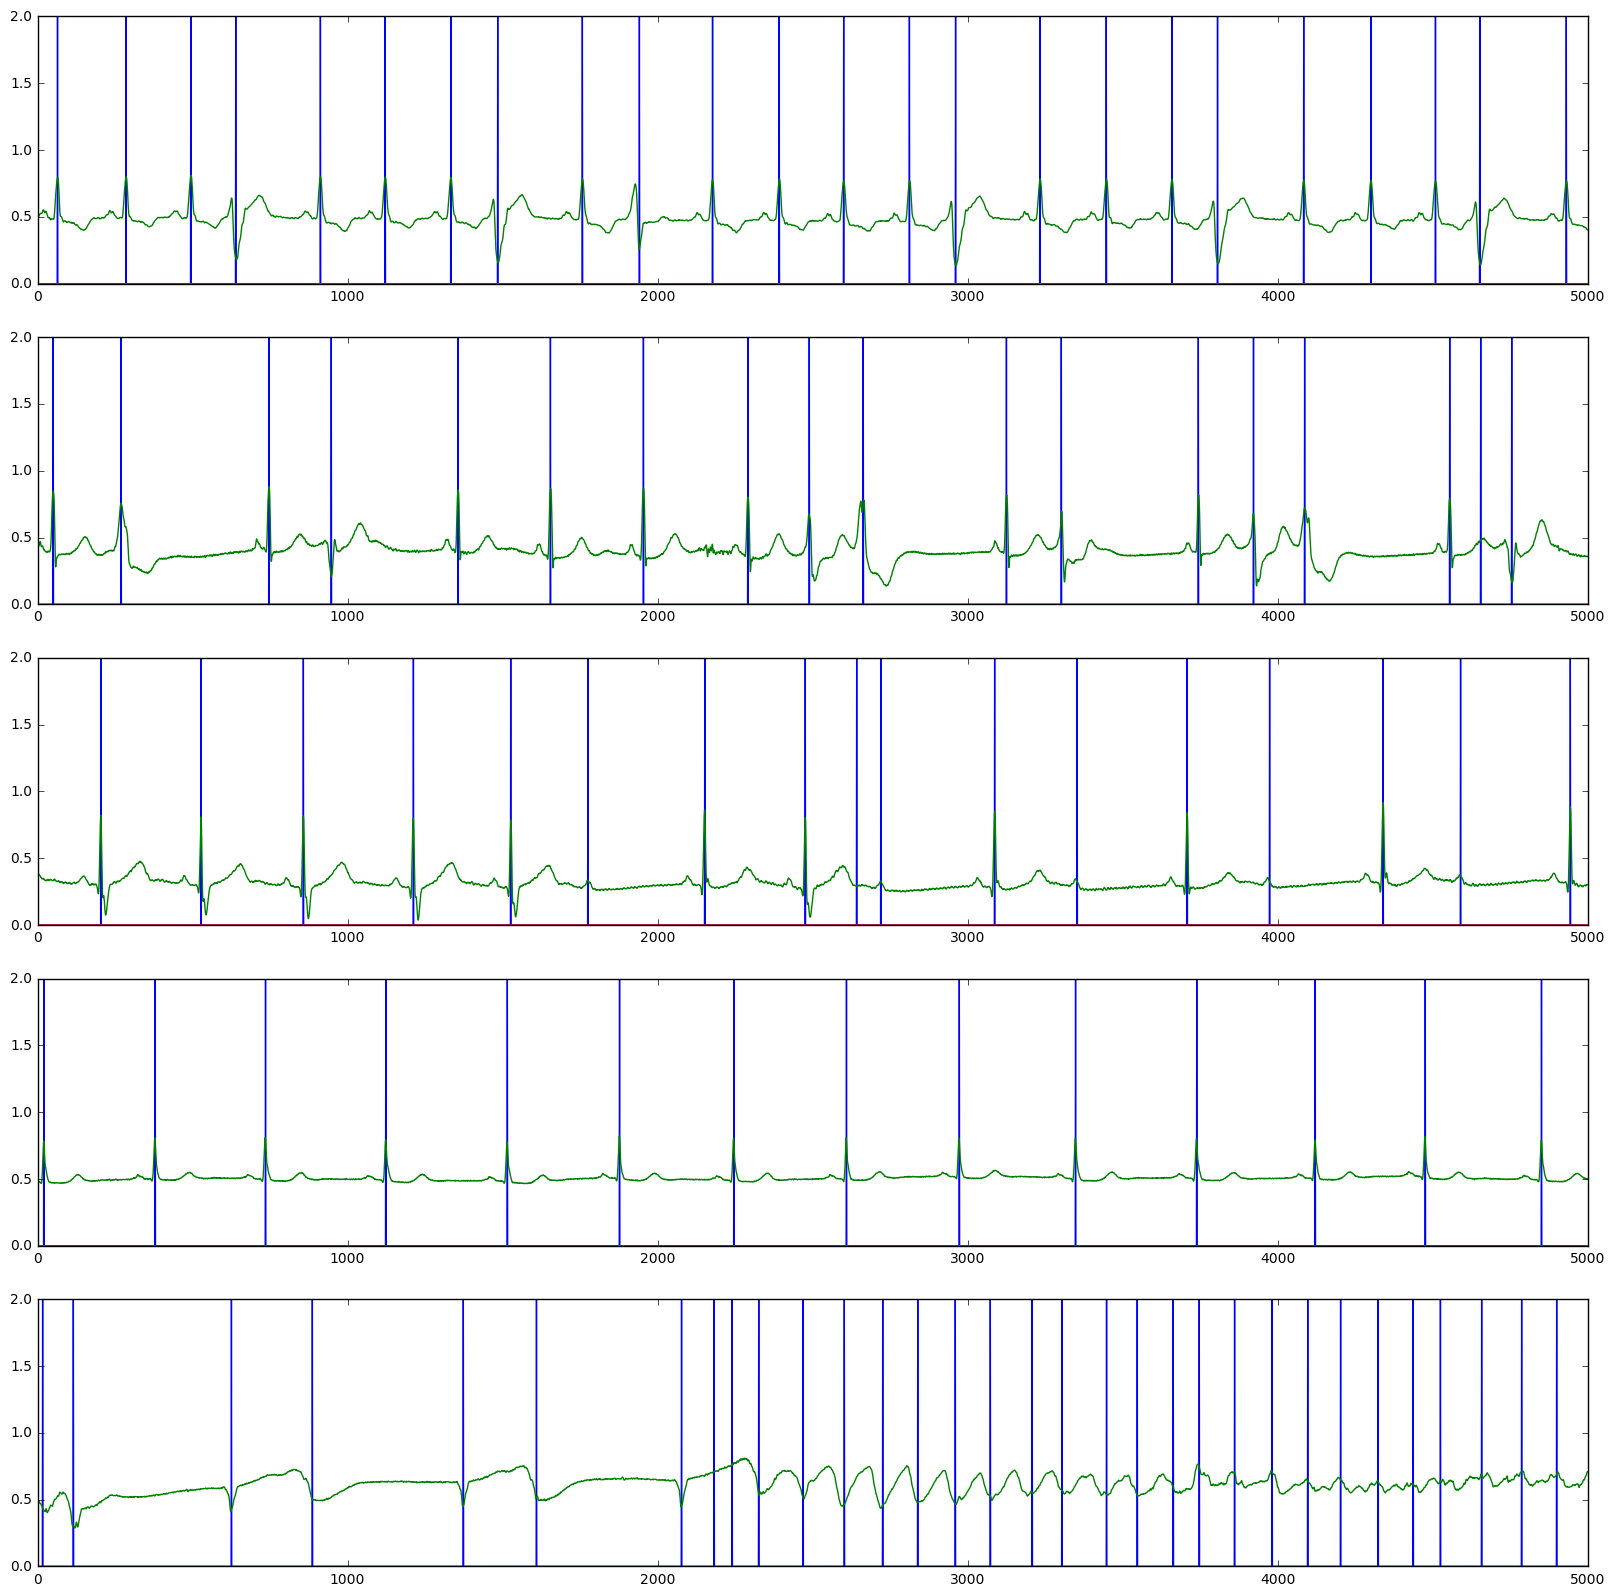

Epoch 102/5000
2/2 [==============================] - 0s


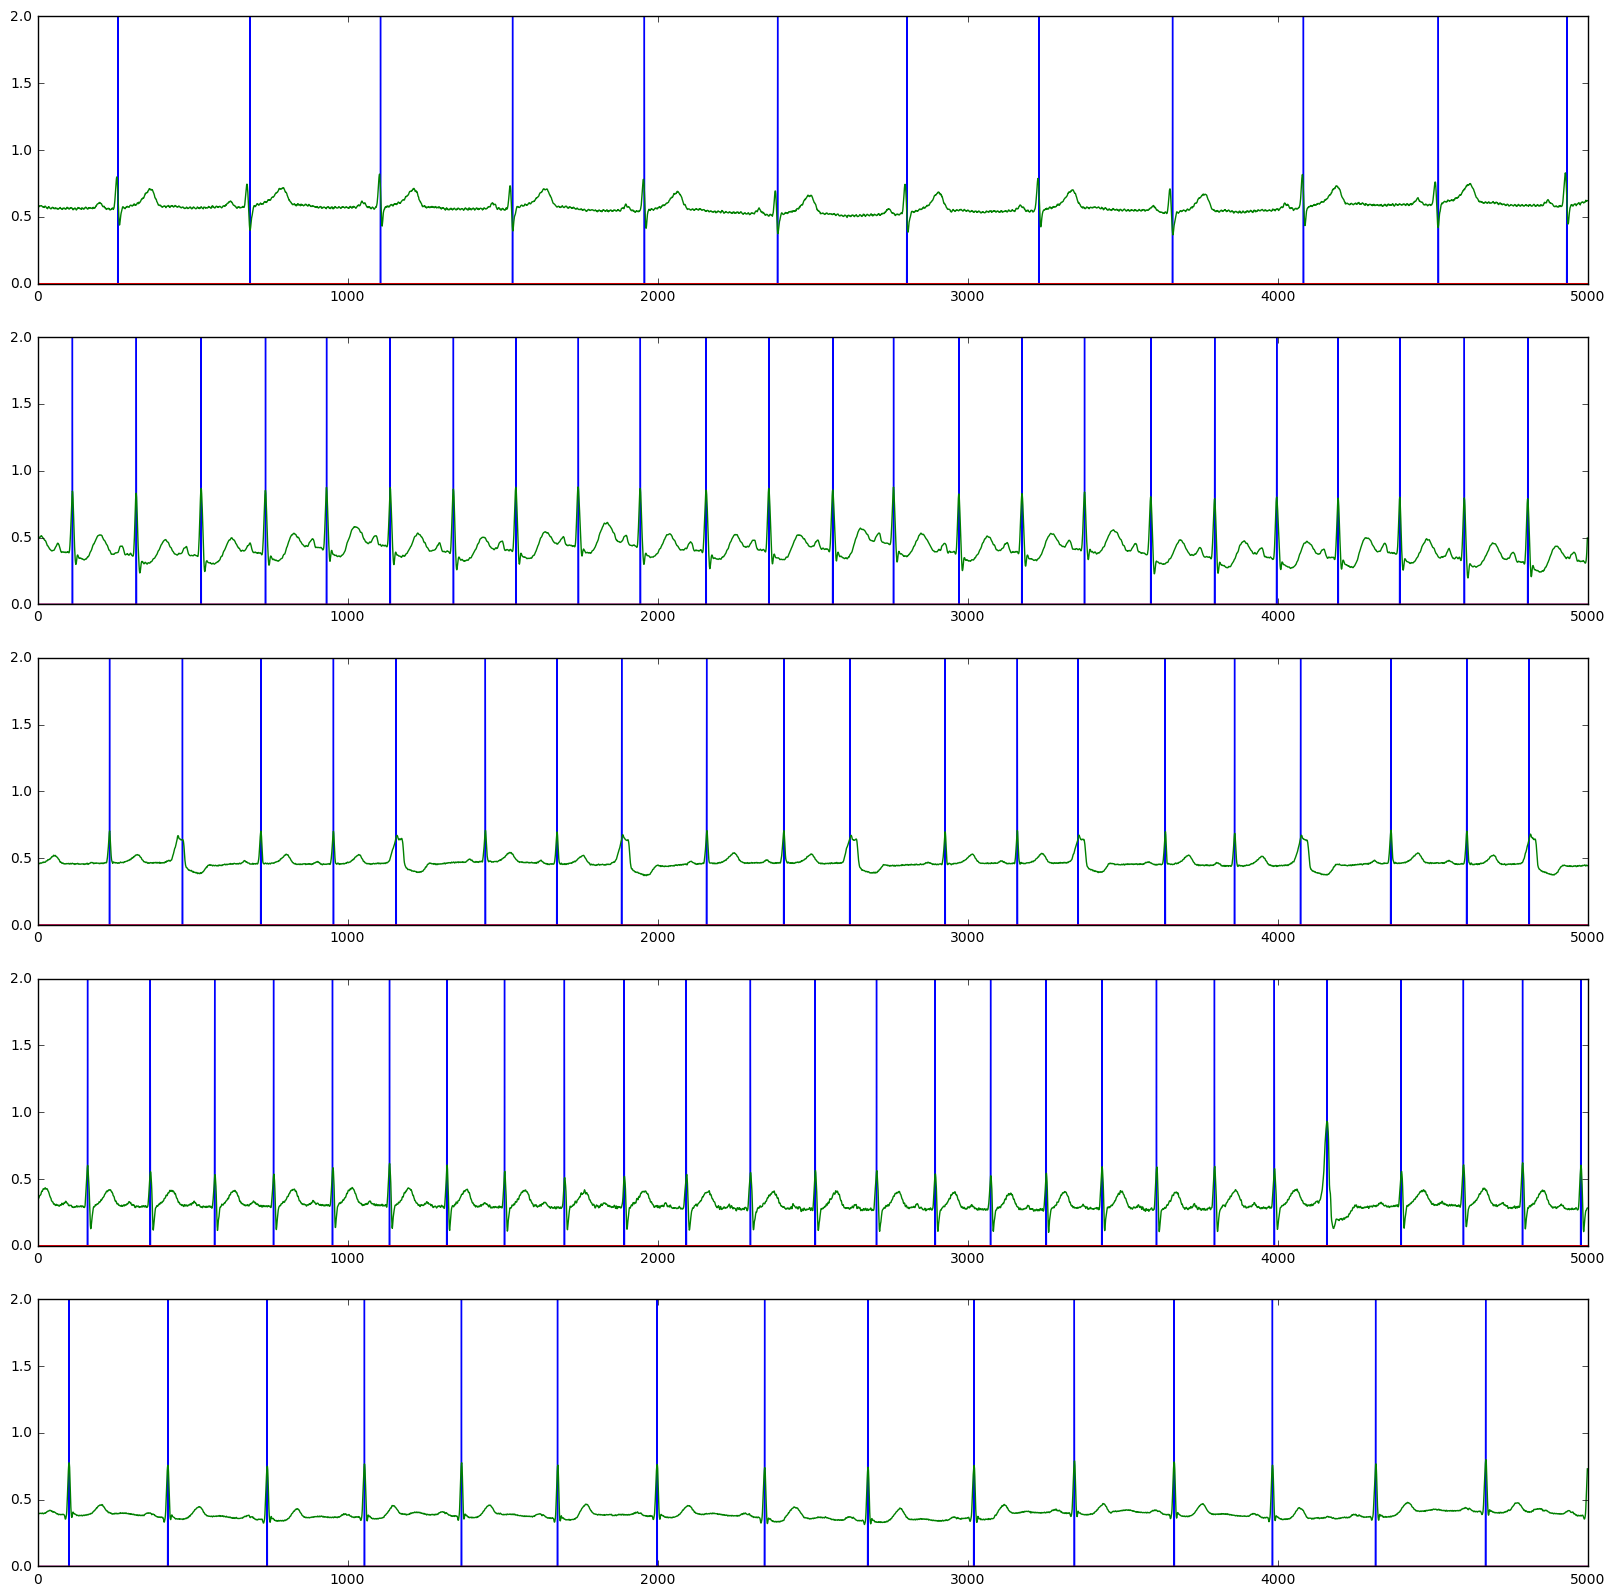

Epoch 103/5000
2/2 [==============================] - 0s


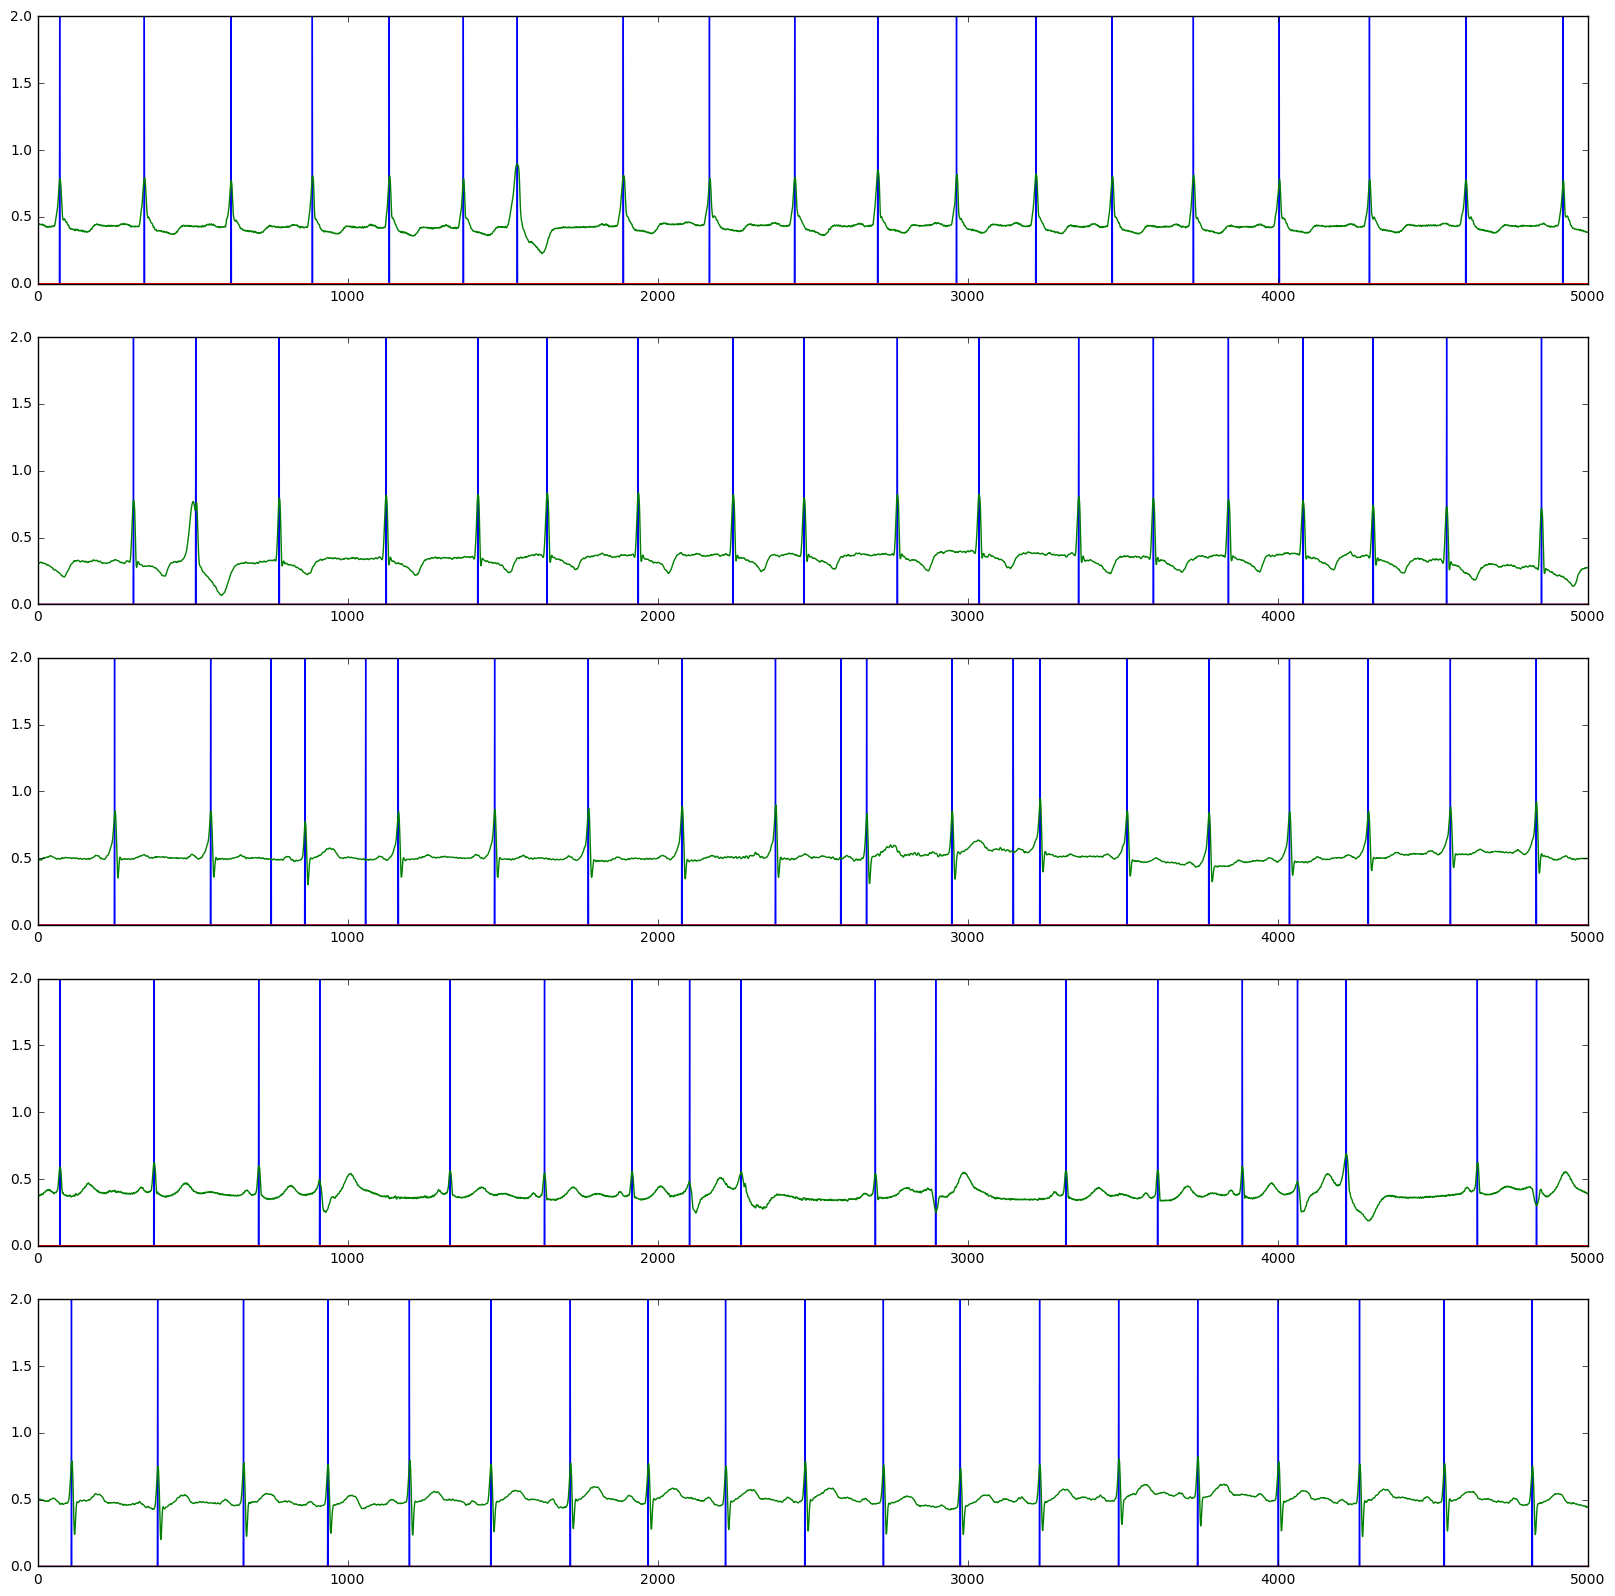

Epoch 104/5000
 145/2000 [=>............................] - ETA: 182s - loss: nan - acc: 0.0000e+00 - se: nan - sp: nan - mmc: nan - rp: nan

KeyboardInterrupt: 

In [22]:
# del model
model = model7

model_load = 'logs/' + mdl_name + '/weights.92-0.21-0.92.hdf5'
model_epoch = 92
model.load_weights(model_load)

samples_used = 0
def gen_samples(XY):
    while True:
        print('CALLED')
        for i in range(XY.shape[0]):
            # samples_used += 
            yield (numpy.asarray([XY[i,0]]), numpy.asarray([XY[i,1]]))
            

def plot_callback():
    exs = numpy.random.randint(len(testXY), size=5).tolist()
    fig, ax = plt.subplots(len(exs), figsize=(20, 20))
    for i, ex_id in enumerate(exs):
        res = [e[0] for e in model.predict_classes(testXY[ex_id]).tolist()[0]]
        ax[i].plot(testXY[ex_id, 1]*2, color='blue')
        ax[i].plot(testXY[ex_id, 0], color='green')
        ax[i].plot(res, color='red')
    plt.show()

mkdir_p('logs/' + mdl_name)
tbCallBack = TensorBoard(log_dir='./logs/{}'.format(mdl_name), histogram_freq=1, write_graph=True, write_images=True)
plotClbk = LambdaCallback(on_epoch_begin=lambda epoch, logs: plot_callback())
ckpt = ModelCheckpoint('logs/' + mdl_name + '/' + 'weights.{epoch:02d}-{loss:.2f}-{acc:.2f}.hdf5', monitor='loss', verbose=1)

history = model.fit_generator(gen_samples(trainXY),
                              steps_per_epoch=2000,
                              epochs=5000,
                              verbose=1,
                              callbacks=[tbCallBack, plotClbk, ckpt],
                              initial_epoch=93)